In [146]:
import os
from functools import partial
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dcor

import sys
sys.path.append("/home/yangz2/projects/1906-pcgml/pcgml-gmmVae-exp/modules/")

from metrics import Metrics
m = Metrics(game='smba')

In [147]:
path_to_gens = "../smba_generations"
path_to_gens_2 = "/home/yangz2/projects/1906-pcgml/pcgml-gmmVae-exp/demos/generated_chunks"
os.listdir(path_to_gens), os.listdir(path_to_gens_2)

(['smba_gmvae_8_10000.json',
  'smba_vae_gaussian_loss_10000.json',
  '.ipynb_checkpoints',
  'smba_gmvae_8.json',
  'smba_gmvae_28.json',
  'smba_gmvae_68.json',
  'smba_gmvae_1_10000.json',
  'smba_gmvae_88.json',
  'smba_gmvae_108.json',
  'smba_vae_kld_loss_10000.json',
  'smba_gmvae_28_10000.json',
  'smba_gmvae_128.json',
  'smba_vae_kld_loss_v2_10000.json',
  'smbWithPath-allLevels-chunks-int-Copy1.json',
  'smba_gmvae_1.json',
  'smba_gmvae_48.json'],
 ['kia_gmms.json',
  '.ipynb_checkpoints',
  'smba_gmms_suboptim.json',
  'kia_gmms_suboptim.json',
  'smba_gens.json',
  'smba_gmms.json',
  'kia_gens.json'])

In [148]:
def load_json_as_array(json_fpath):
    with open(json_fpath, "r") as json_f:
        return np.array(json.load(json_f))

In [149]:
def get_metrics_from_chunks(chunks):
    return m.compute_metrics_for_arrays(
        arrays=chunks, 
        metrics_to_compute=['linearity', 'leniency', 'num_jumps', 'density', 'interestingness']
    )

Generations whose metrics have already been calculated don't need to be calculated again.

In [170]:
try:
    with open('metrics_per_json.json', 'r') as json_f:
        metrics_per_json = json.load(json_f)
    finished_json_fnames = list(metrics_per_json.keys())
except:
    metrics_per_json = {}

In [171]:
refresh = False
if refresh:
    metrics_per_json = {}
    finished_json_fnames = []

In [172]:
finished_json_fnames

['smba_gmvae_8_10000.json',
 'smba_vae_gaussian_loss_10000.json',
 'smba_gmvae_1_10000.json',
 'smba_vae_kld_loss_10000.json',
 'smba_gmvae_28_10000.json',
 'smba_vae_kld_loss_v2_10000.json',
 'smbWithPath-allLevels-chunks-int-Copy1.json',
 'smba_gens.json']

In [153]:
json_fnames = [fname for fname in os.listdir(path_to_gens) if fname.split('.')[-1] == 'json' and ('10000' in fname or 'smbWithPath' in fname)]

for json_fname in tqdm_notebook(json_fnames):
    
    if json_fname not in finished_json_fnames:
        
        json_fpath = os.path.join(path_to_gens, json_fname)
        chunks = load_json_as_array(json_fpath)
        metrics_per_json[json_fname] = get_metrics_from_chunks(chunks)
        
json_fpath = os.path.join(path_to_gens_2, "smba_gens.json")
chunks = load_json_as_array(json_fpath)
metrics_per_json["smba_gens.json"] = get_metrics_from_chunks(chunks)

In [154]:
with open('metrics_per_json.json', 'w+') as json_f:
    for k, v in metrics_per_json.items(): 
        metrics_per_json[k] = np.array(v).tolist()
    json.dump(metrics_per_json, json_f)

## Compare the distributions of metrics for different models

In [155]:
metrics = ['linearity', 'leniency', 'num_jumps', 'density', 'interestingness']

In [156]:
with open('metrics_per_json.json', 'r') as json_f:
    
    metrics_per_json_np = {}
    for k, v in metrics_per_json.items():
        metrics_per_json_np[k] = np.array(v).T
        
    metrics_array = []
    for k, v in metrics_per_json_np.items():
        metrics_array.append(np.hstack([v, np.array([k] * len(v)).reshape(-1, 1)]))
        
    metrics_array = np.vstack(metrics_array)

In [157]:
df = pd.DataFrame(metrics_array)

In [158]:
df.columns = metrics + ["components"]

In [179]:
replace_dict = {
    'smbWithPath-allLevels-chunks-int-Copy1.json' : 'Training data',
    'smba_gens.json' : 'VAE, KLD loss / 64, 10000 epochs',
    'smba_vae_kld_loss_v2_10000.json' : 'VAE, 2 * KLD loss, 10000 epochs',
    'smba_vae_gaussian_loss_10000.json' : 'VAE, Gaussian loss, 10000 epochs',
    'smba_gmvae_1_10000.json' : 'GM-VAE, 1 component, 10000 epochs',
    'smba_gmvae_8_10000.json' : 'GM-VAE, 8 components, 10000 epochs',
    'smba_gmvae_28_10000.json' : 'GM-VAE, 28 components, 10000 epochs'
}

In [180]:
df = df.replace(replace_dict)

In [181]:
df.head(10)

,linearity,leniency,num_jumps,density,interestingness,components
0,4.293842,2.0,2.0,18.750000,0.0,"GM-VAE, 8 components, 10000 epochs"
1,4.923529,1.0,1.0,22.656250,0.0,"GM-VAE, 8 components, 10000 epochs"
2,2.293934,-1.0,1.0,10.156250,2.0,"GM-VAE, 8 components, 10000 epochs"
3,4.587592,2.0,2.0,27.343750,0.0,"GM-VAE, 8 components, 10000 epochs"
4,8.201930,2.0,2.0,29.687500,3.0,"GM-VAE, 8 components, 10000 epochs"
5,0.000000,2.0,1.0,18.750000,8.0,"GM-VAE, 8 components, 10000 epochs"
6,5.535110,0.0,1.0,13.671875,1.0,"GM-VAE, 8 components, 10000 epochs"
7,2.746783,1.0,1.0,19.531250,0.0,"GM-VAE, 8 components, 10000 epochs"
8,8.269945,2.0,0.0,27.734375,3.0,"GM-VAE, 8 components, 10000 epochs"
9,4.227298,4.0,1.0,17.187500,4.0,"GM-VAE, 8 components, 10000 epochs"


In [182]:
df[metrics] = df[metrics].astype(float)
df['components'] = df['components'].astype('category')

In [183]:
df.dtypes

linearity           float64
leniency            float64
num_jumps           float64
density             float64
interestingness     float64
components         category
dtype: object

In [184]:
def get_energy_distance(array, metric:str):
    return dcor.energy_distance(df.loc[df['components'] == 'Training data'][metric], array)

In [185]:
# interestingness_edist = df.groupby('components').interestingness.agg(partial(get_energy_distance, metric='interestingness'))
# interestingness_edist.to_json('interestingness_edist.json')

In [186]:
interestingness_edist = pd.read_json('interestingness_edist.json', typ='series')

In [187]:
# density_edist = df.groupby('components').density.agg(partial(get_energy_distance, metric='density'))
# density_edist.to_json('density_edist.json')

In [188]:
density_edist = pd.read_json('density_edist.json', typ='series')

In [189]:
interestingness_edist[list(replace_dict.values())]

Training data                          0.000000
VAE, KLD loss / 64, 10000 epochs       1.422654
VAE, 2 * KLD loss, 10000 epochs        0.050697
VAE, Gaussian loss, 10000 epochs       0.007101
GM-VAE, 1 component, 10000 epochs      0.055183
GM-VAE, 8 components, 10000 epochs     0.160777
GM-VAE, 28 components, 10000 epochs    0.171483
dtype: float64

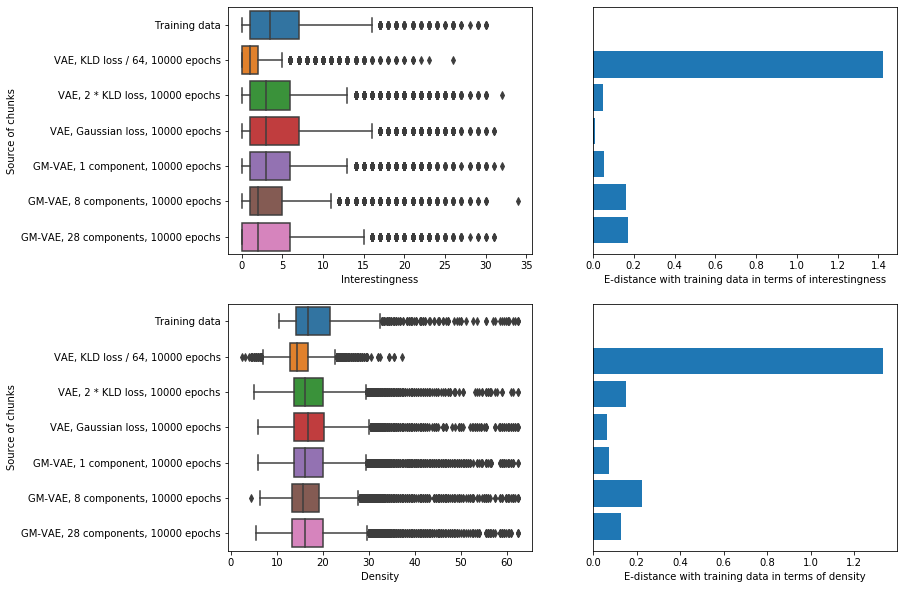

In [190]:
fig = plt.figure(figsize=(12, 10))

fig.add_subplot(221)
sns.boxplot(x=df.interestingness, y=df.components, order=list(replace_dict.values()), ax=plt.gca())
plt.ylabel('Source of chunks'); plt.xlabel('Interestingness')

fig.add_subplot(222)
plt.barh(
    list(reversed(list(replace_dict.values()))),
    list(reversed(interestingness_edist[list(replace_dict.values())]))
)
plt.gca().get_yaxis().set_visible(False)
plt.xlabel('E-distance with training data in terms of interestingness')

fig.add_subplot(223)
sns.boxplot(x=df.density, y=df.components, order=list(replace_dict.values()), ax=plt.gca())
plt.ylabel('Source of chunks'); plt.xlabel('Density')

fig.add_subplot(224)
plt.barh(
    list(reversed(list(replace_dict.values()))),
    list(reversed(density_edist[list(replace_dict.values())]))
)
plt.gca().get_yaxis().set_visible(False)
plt.xlabel('E-distance with training data in terms of density')

plt.savefig('distributions_of_metrics_for_different_models.png')

## Compute 95% boostrap confidence interval for each distance

In [55]:
def bootstrap_ci(org_mets, gen_mets, confidence_level=0.95, num_bootstraps=10):
    
    # org_mets and gen_mets are of shape (num_chunks, num_metrics)
    
    num_org = len(org_mets)
    num_gen = len(gen_mets)
    
    e_distances = []
    
    for i in tqdm_notebook(np.arange(num_bootstraps)):
    
        random_idxs_org = np.random.randint(num_org, size=num_org)
        random_idxs_gen = np.random.randint(num_gen, size=num_gen)
    
        org_mets_samp = org_mets[random_idxs_org]
        gen_mets_samp = gen_mets[random_idxs_gen]
        
        e_distances.append(dcor.energy_distance(org_mets_samp, gen_mets_samp))
        
    ordered = sorted(e_distances)
    lower = np.percentile(ordered, (1-confidence_level)/2 * 100)
    upper = np.percentile(ordered, (confidence_level+((1-confidence_level)/2)) * 100)

    return lower, upper

In [56]:
org_idx = 6
org_mets = metrics_per_json_np[org_idx]
lowers = []
uppers = []
for mets in tqdm_notebook(metrics_per_json_np):
    lower, upper = bootstrap_ci(org_mets.T, mets.T)
    lowers.append(lower)
    uppers.append(upper)

In [75]:
with open("lowers.json", "w+") as json_f:
    json.dump(lowers, json_f)

In [76]:
with open("uppers.json", "w+") as json_f:
    json.dump(uppers, json_f)

In [7]:
with open("lowers.json", "r") as json_f:
    lowers = json.load(json_f)

In [8]:
with open("uppers.json", "r") as json_f:
    uppers = json.load(json_f)

## Compute distances

In [9]:
org_idx = 6
org_mets = metrics_per_json_np[org_idx]
e_distances = []
for i, mets in enumerate(metrics_per_json_np):
    e_distances.append(dcor.energy_distance(org_mets.T, mets.T))

KeyboardInterrupt: 

In [ ]:
with open("e_distances.json", "w+") as json_f:
    json.dump(e_distances, json_f)

In [10]:
with open("e_distances.json", "r") as json_f:
    e_distances = json.load(json_f)

In [11]:
num_components_array = [8, 28, 68, 88, 108, 128, 0, 1, 48]

## Plot distances against number of components

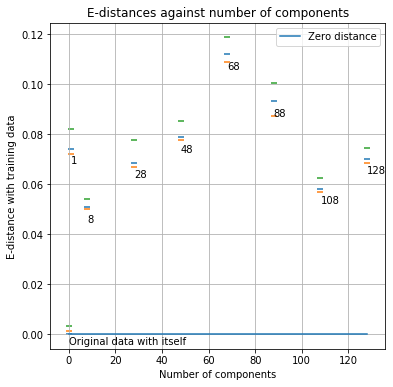

In [14]:
plt.figure(figsize=(6, 6))

plt.title('E-distances against number of components')

plt.scatter(num_components_array, e_distances, marker="_")
plt.plot([0, 128], [0, 0], label='Zero distance')

for x, y in zip(num_components_array, e_distances):
    if x == 0:
        plt.annotate("Original data with itself", xy=(x, y-0.004))
    else:
        plt.annotate(f"{x}", xy=(x, y-0.006))

# confidence bounds
plt.scatter(num_components_array, lowers, marker='_')
plt.scatter(num_components_array, uppers, marker='_')

plt.xlabel('Number of components'); plt.ylabel('E-distance with training data')
plt.legend(loc="upper right")
plt.grid()

plt.show()